# TestBoard

## 练习1：波士顿灰熊问题（第7章正文）

In [1]:
from thinkbayes2 import *
import thinkplot
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
hockey_data = pd.read_csv("hockey_data.csv")

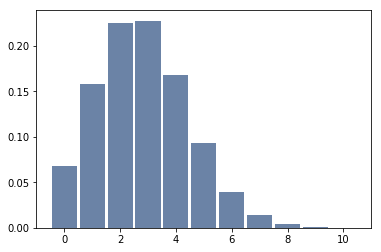

In [3]:
# score = pd.concat((hockey_data.Pd1, hockey_data.Pd2, hockey_data.Pd3, hockey_data.OT, hockey_data["SO Win"]))
# score10_11 = hockey_data[hockey_data.Season.apply(lambda x:True if 2010<=x<=2011 else False)][["Pd1","Pd2","Pd3","OT","SO Win"]].sum(axis=1)
score = hockey_data[["Pd1","Pd2","Pd3","OT","SO Win"]].sum(axis=1)

pmf = Pmf(score)
thinkplot.Hist(pmf)
plt.show()

In [4]:
# score_esti_pdf = EstimatedPdf(score)
mu = np.mean(score)
print(type(score))
sigma = np.std(score)
print(mu, sigma)

<class 'pandas.core.series.Series'>
2.81321138211 1.65237826017


In [5]:
class Team(Suite):
    def __init__(self, mu, sigma, label = DEFAULT_LABEL):
        self.score_rate_pdf = NormalPdf(mu, sigma)
        Suite.__init__(self, self.score_rate_pdf.MakePmf(), label=label)
    
    def Likelihood(self, data, hypo):
        like = EvalPoissonPmf(lam=hypo, k=data)
        return like

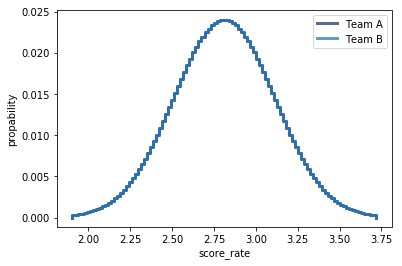

In [6]:
t1 = Team(mu=2.81,sigma=0.3, label="Team A")
t2 = Team(mu=2.81,sigma=0.3, label="Team B")
thinkplot.Pmfs([t1,t2])
thinkplot.Config(xlabel="score_rate", ylabel="propability", legend=True)
plt.show()

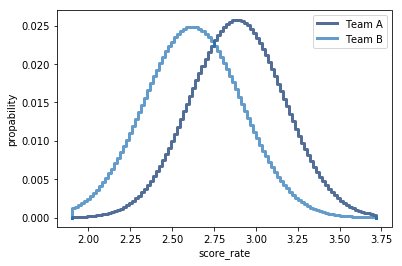

In [7]:
t1.UpdateSet([0,2,8,4])
t2.UpdateSet([1,3,1,0])
thinkplot.Pmfs([t1,t2])
thinkplot.Config(xlabel="score_rate", ylabel="propability", legend=True)

plt.show()

In [8]:
def MakeGoalPmf(team, high = 10):
    goal_pmf = Pmf()
    for goal_rate, prob in team.Items():
        goal_pmf.Set(MakePoissonPmf(lam=goal_rate, high=high), prob)
    goal_pmf.Normalize()
    return MakeMixture(goal_pmf)

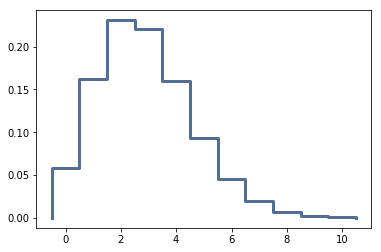

In [9]:
t1_goal_pmf = MakeGoalPmf(t1)
thinkplot.Pmf(t1_goal_pmf)
plt.show()

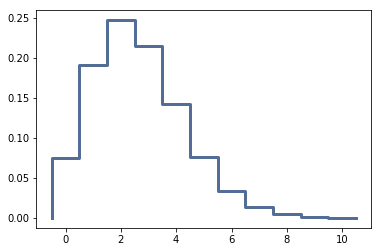

In [10]:
t2_goal_pmf = MakeGoalPmf(t2)
thinkplot.Pmf(t2_goal_pmf)
plt.show()

/home/tao/tao/LearningBayes/code/thinkplot.py:370: UserWarning: Hist: Can't compute bar width automatically.Check for non-numeric types in Hist.Or try providing width option.
  warnings.warn("Hist: Can't compute bar width automatically."


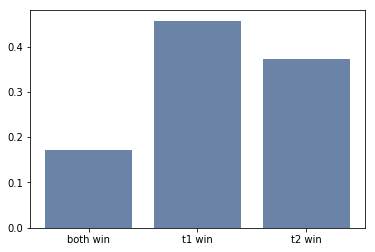

both win 0.171478459755
t1 win 0.456923952565
t2 win 0.37159758768


In [11]:
t1_t2 = t1_goal_pmf - t2_goal_pmf

p_t1_win = 0
p_t2_win = 0
p_both_win = 0

for score_diff, prob in t1_t2.Items():
    if score_diff > 0:
        p_t1_win += prob
    elif score_diff < 0:
        p_t2_win += prob
    else:
         p_both_win += prob
result = MakePmfFromDict({"t1 win":p_t1_win,"both win":p_both_win,"t2 win":p_t2_win})
thinkplot.Hist(result)
plt.show()
result.Print()

In [12]:
def MakeExponentialPmf(lam, high, n=200):
    """
    Makes a PMF discrete approx to an exponential distribution.

    lam: parameter lambda in events per unit time
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    pmf = Pmf()
    for x in np.linspace(0, high, n):
        p = EvalExponentialPdf(x, lam)
        pmf.Set(x, p)
#     pmf.Normalize()
    return pmf

In [13]:
# 上面的概率中bothwin的情况还有进行加时赛
# 所以还需要求解加时赛中team1胜利的概率
# 类似的，使用泊松分布进行建模
# tmp1 = MakeExponentialPmf(lam=2.8, high=1, n=100)
# tmp2 = MakeExponentialPmf(lam=2.8, high=1, n=200)
# tmp3 = MakeExponentialPmf(lam=2.8, high=1, n=300)

# tmp1.label = "1"
# tmp2.label = "2"
# tmp3.label = "3"

# thinkplot.Pmfs([tmp1, tmp2, tmp3])
# thinkplot.Config(legend=True)
# plt.show()
# del tmp1, tmp2, tmp3
def MakeGoalTimePmf(team, sample_points_num=100, time_limit=1, label = DEFAULT_LABEL):
    goal_time_pmf = Pmf()
    for goal_rate, prob in team.Items():
        goal_time_pmf.Set(MakeExponentialPmf(lam=goal_rate, n=sample_points_num, high=time_limit), prob)
    
    mix = MakeMixture(goal_time_pmf, label=label)
    mix.Normalize()
    return mix

        
    



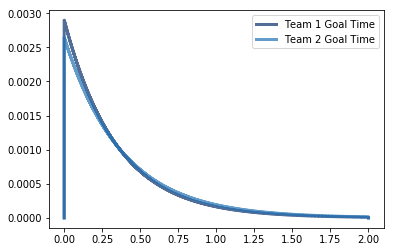

In [19]:
goal_time_pmf1 = MakeGoalTimePmf(t1, sample_points_num=2000, time_limit=2, label="Team 1 Goal Time")
goal_time_pmf2 = MakeGoalTimePmf(t2, sample_points_num=2000, time_limit=2, label="Team 2 Goal Time")
thinkplot.Pmfs([goal_time_pmf1, goal_time_pmf2])
thinkplot.Config(legend = True)
plt.show()


/home/tao/tao/LearningBayes/code/thinkplot.py:370: UserWarning: Hist: Can't compute bar width automatically.Check for non-numeric types in Hist.Or try providing width option.
  warnings.warn("Hist: Can't compute bar width automatically."


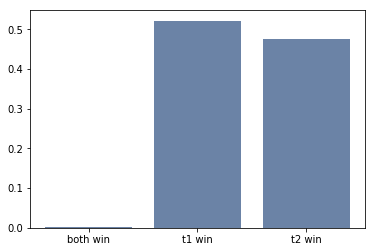

both win 0.00138315593835
t1 win 0.522045796759
t2 win 0.476571047303


In [20]:
t1_t2_time = goal_time_pmf1 - goal_time_pmf2

p_t1_win = 0
p_t2_win = 0
p_both_win = 0

for score_diff, prob in t1_t2_time.Items():
    if score_diff < 0:
        p_t1_win += prob
    elif score_diff > 0:
        p_t2_win += prob
    else:
         p_both_win += prob
result = MakePmfFromDict({"t1 win":p_t1_win,"both win":p_both_win,"t2 win":p_t2_win})
thinkplot.Hist(result)
plt.show()
result.Print()

In [18]:
print(515/470)
print(508/463)

1.0957446808510638
1.0971922246220303


##

公交车到站间隔是20分钟，你到站的时间是随机的，那么你等待公交车的时间在0到20之间均匀分布。
但是现实生活中，公交车的到站间隔是有变动的

5.0 0.16666666666666666
6.0 0.16666666666666666
7.0 0.16666666666666666
8.0 0.16666666666666666
9.0 0.16666666666666666
10.0 0.16666666666666666


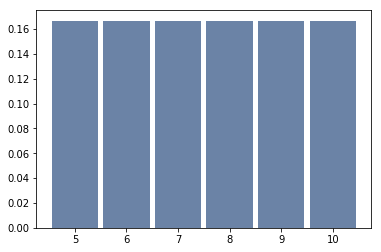

In [14]:
pmf = MakeUniformPmf(5,10,6)
pmf.Print()
thinkplot.Hist(pmf)
plt.show()

In [26]:
def MakePmfOfWaitTime(pmf):
    metapmf = Pmf()
    for gap, prob in pmf.Items():
        metapmf.Set(MakeUniformPmf(0,gap,gap+1), prob)
    print(metapmf)
    return MakeMixture(metapmf)

def BiasPmf(pmf):
    new_pmf = pmf.Copy()
    for x, p in pmf.Items():
        new_pmf.Mult(x, x)
        
    new_pmf.Normalize()
    return new_pmf

class WaitTimeCalculator(object):
    def __init__(self, pmf_z):
        self.pmf_z = pmf_z
        self.pmf_zb = BiasPmf(pmf_z)
        self.pmf_y = self.PmfOfWaitTime(pmf_zb)
        self.pmf_x = self.pmf_y
        
    def PmfOfWaitTime(pmf):
        metapmf = Pmf()
        for gap, prob in pmf.Items():
            metapmf.Set(MakeUniformPmf(0,gap,gap+1), prob)
        print(metapmf)
        return MakeMixture(metapmf)

In [30]:
pmf = Pmf({10:0.5, 5:0.5})
print(pmf.Mean())
pmf = BiasPmf(pmf)
pmf.Print()
print(pmf.Mean())

7.5
5 0.3333333333333333
10 0.6666666666666666
8.333333333333332


In [31]:
MakePmfOfWaitTime(pmf)

Pmf({Pmf({0.0: 0.09090909090909091, 1.0: 0.09090909090909091, 2.0: 0.09090909090909091, 3.0: 0.09090909090909091, 4.0: 0.09090909090909091, 5.0: 0.09090909090909091, 6.0: 0.09090909090909091, 7.0: 0.09090909090909091, 8.0: 0.09090909090909091, 9.0: 0.09090909090909091, 10.0: 0.09090909090909091}): 0.6666666666666666, Pmf({0.0: 0.16666666666666666, 1.0: 0.16666666666666666, 2.0: 0.16666666666666666, 3.0: 0.16666666666666666, 4.0: 0.16666666666666666, 5.0: 0.16666666666666666}): 0.3333333333333333})


Pmf({0.0: 0.11616161616161616, 1.0: 0.11616161616161616, 2.0: 0.11616161616161616, 3.0: 0.11616161616161616, 4.0: 0.11616161616161616, 5.0: 0.11616161616161616, 6.0: 0.06060606060606061, 7.0: 0.06060606060606061, 8.0: 0.06060606060606061, 9.0: 0.06060606060606061, 10.0: 0.06060606060606061}, 'mix')